# Zernike 3D 


In [23]:
import numpy as np
import matplotlib.pyplot as plt

from mayavi import mlab
from scipy.special import sph_harm
from math import factorial as fact
from math import pi, sqrt, sin, cos, atan2

def binomial(n, k): return fact(n)  / (fact(k) * fact(n - k))

In [71]:
class Zernike3D:
    def __init__(self, IMG3D: np.array):
        self.IMG3D = IMG3D

    def radial(self, n: int, l: int) -> ():
        """Radial Zernike polynomials normalized for 3D case for given order n, l."""
        # normalization factor
        Q = lambda k, l, nu: ((-1)**(k + nu) / 4**k) *\
                             sqrt((2 * l + 4 * k + 3) / 3) *\
                             (binomial(2 * k, k) * binomial(k, nu) * binomial(2 * (k + l + nu) + 1, 2 * k) / binomial(k + l + nu, k))
        if (n - l) % 2 != 0: 
            return lambda r: 0
        else:
            return lambda r: sum([Q((n - l) / 2, l, nu) * r**(2 * nu + l) for nu in range((n - l) // 2 + 1)]) 
    
    def moment(self, n: int, l: int, m: int) -> ():
        """Zernike 3D moment of given order n, l, m."""
        # check parameters validity
        # init radial part
        R = self.radial(abs(n), abs(l))
        # moment function
        def Z(x, y, z) -> ():
            if x**2 + y**2 + z**2 > 1:
                return 0
            else:
                r = sqrt(x**2 + y**2 + z**2)
                theta = atan2(sqrt(x**2 + y**2), z)
                phi = atan2(y, x)
                return  R(r) * sph_harm(m, l, theta, phi)
        return Z

    def descriptor(self, n: int) -> list:
        """Zernike 3D descriptor vector of given order for 3D image."""
        # determine the Zernike moments on the grid of the given 3D image
        # excluding points with zero x, y, z uncertainty 0 / 0 or inf / 0
        vector = []
        max_x, max_y, max_z = self.IMG3D.shape[:3]
        dx, dy, dz = 2 / (max_x - 1), 2 / (max_y - 1), 2 / (max_z - 1)
        x, y, z = np.arange(-1, 1 + dx, dx), np.arange(-1, 1 + dy, dy), np.arange(-1, 1 + dz, dz)
        # calculate the normalization factor
        norm_factor = 3 / (4 * pi)
        # calculate allowed modes for given n
        allowed_modes = [(0,0,0), (1,1,0), (1,1,1), (2,0,0), (3,1,1), (4,0,0)]
        
        print('Allowed modes')
        for m in allowed_modes:
            print(m)

        for ni, li, mi in allowed_modes:
            Z = self.moment(ni, li, mi)
            A = np.array([[[np.real(Z(xi, yi, zi)) for xi in x] for yi in y] for zi in z])
            component = np.sum(A * self.IMG3D) / norm_factor
            vector.append((ni, li, mi, component))
        return vector

    def plot_radial(self, n: int, l: int):
        """Plot radial Zernike polynom of order n."""
        R = self.radial(n, l)
        x = np.arange(0, 1, 0.01)
        y = np.array([R(r) for r in x])

        plt.figure(dpi=100)
        plt.plot(x, y)
        plt.xlim(0, 1.1)
        plt.ylabel(f'$R_{n}^{l}(r)$')
        plt.xlabel('r')
        plt.show()

    def plot_moment_slice(self, n: int, l: int, m: int, lattitude: int=1):
        """Plot 3D Zernike moment slice at the level lattitude * grid_step."""
        Z = self.moment(n, l, m)
        d = 0.01
        x = np.concatenate([np.arange(-1, -d, d), np.arange(d, 1 + d, d)])
        z = np.array([[np.real(Z(xi, yi, lattitude * d)) for xi in x] for yi in x])

        plt.figure(dpi=100)
        plt.imshow(z, cmap='rainbow')
        plt.show()

    def plot_moment_3d(self, n: int, l: int, m: int):
        """Plot 3D zernike moment in 3D as density plot."""
        pass

def make_3D_img_from_spheres(spheres, ds=0.1):
    """Make 3D image from spheres: (x,y,z,r)."""
    smpl = np.arange(-1, 1, ds)
    N = smpl.shape[0]
    grid = np.zeros((N, N, N))

    for xi, yi, zi, ri in spheres:
        for i, x in enumerate(smpl):
            for j, y in enumerate(smpl):
                for k, z in enumerate(smpl):
                    if (x - xi)**2 + (y - yi)**2 + (z - zi)**2 <= ri**2:
                        grid[i,j,k] = 1
    
    return grid

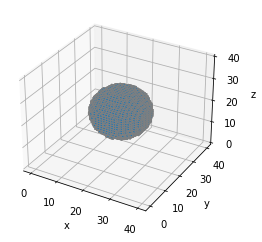

In [76]:
test_structure = [(0, 0, 0, 0.5)] # [(0.5, 0, 0, 0.2), (-0.5, 0, 0, 0.2)]
test_3d_image = make_3D_img_from_spheres(test_structure, ds=0.05)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.voxels(test_3d_image, edgecolors='gray', shade=False)
plt.show()



In [77]:
zen = Zernike3D(test_3d_image)

#zen.plot_radial(1, 1)

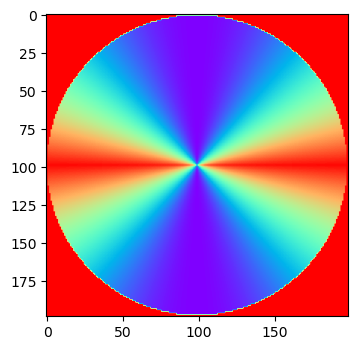

In [75]:
zen.plot_moment_slice(1, 1, 1, 1)

In [78]:
zen.descriptor(2)


Allowed modes
(0, 0, 0)
(1, 1, 0)
(1, 1, 1)
(2, 0, 0)
(3, 1, 1)
(4, 0, 0)


[(0, 0, 0, 4901.425715704054),
 (1, 1, 0, 323.53452866412783),
 (1, 1, 1, -125.00224762114054),
 (2, 0, 0, -8260.123452787406),
 (3, 1, 1, 264.6413615589792),
 (4, 0, 0, 6802.450515714753)]

In [29]:
from scipy import stats

mu, sigma = 0, 0.1 
x = 10*np.random.normal(mu, sigma, 5000)
y = 10*np.random.normal(mu, sigma, 5000)    
z = 10*np.random.normal(mu, sigma, 5000)

xyz = np.vstack([x,y,z])
kde = stats.gaussian_kde(xyz)

# Evaluate kde on a grid
xmin, ymin, zmin = x.min(), y.min(), z.min()
xmax, ymax, zmax = x.max(), y.max(), z.max()
xi, yi, zi = np.mgrid[xmin:xmax:30j, ymin:ymax:30j, zmin:zmax:30j]
coords = np.vstack([item.ravel() for item in [xi, yi, zi]]) 
density = kde(coords).reshape(xi.shape)

print(xi[0][0])
print(density[0][0])

# Plot scatter with mayavi
figure = mlab.figure('DensityPlot')

grid = mlab.pipeline.scalar_field(xi, yi, zi, density)
min = density.min()
max=density.max()
mlab.pipeline.volume(grid, vmin=min, vmax=min + .5*(max-min))

mlab.axes()
mlab.show()

[-3.44277523 -3.44277523 -3.44277523 -3.44277523 -3.44277523 -3.44277523
 -3.44277523 -3.44277523 -3.44277523 -3.44277523 -3.44277523 -3.44277523
 -3.44277523 -3.44277523 -3.44277523 -3.44277523 -3.44277523 -3.44277523
 -3.44277523 -3.44277523 -3.44277523 -3.44277523 -3.44277523 -3.44277523
 -3.44277523 -3.44277523 -3.44277523 -3.44277523 -3.44277523 -3.44277523]
[2.16677865e-26 6.80084320e-25 4.04990587e-22 9.29724644e-19
 1.02455459e-15 4.93384088e-13 1.03155722e-10 9.35934016e-09
 3.68488962e-07 6.29549414e-06 4.66725103e-05 1.50147631e-04
 2.09605081e-04 1.26973141e-04 3.33801817e-05 3.82761341e-06
 2.44086392e-07 7.00719537e-08 3.42399144e-08 7.83278182e-09
 8.24952040e-10 4.41547804e-11 1.39195223e-12 2.67549126e-14
 2.75082252e-16 1.33529503e-18 2.90251130e-21 4.43335642e-24
 1.18839735e-25 3.80643522e-27]


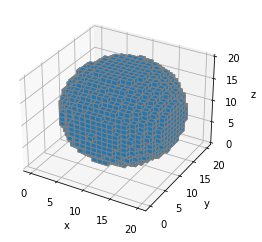

In [19]:
from mpl_toolkits.mplot3d import Axes3D

def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    return ax

def sphere(x, y, z):
    if x**2 + y**2 + z**2 <= 1:
        return 1
    else:
        return 0

filled = np.array([[[sphere(i, j, k) for i in np.arange(-1, 1, 0.1)] for j in np.arange(-1, 1, 0.1)] for k in np.arange(-1, 1, 0.1)])

ax = make_ax(True)
ax.voxels(filled, edgecolors='gray', shade=False)
plt.show()
